# Titanlib nebelhorn data
Titanlib is used operationally at MET Norway for temperature.

### Table of Contents  
- [Load in data](#Load-in-data)
- [Buddy check](#Buddy-check)
- [Buddy event check](#Buddy-event-check)
- [Climatology range check](#Climatology-range-check)
- [Isolation check](#Isolation-check)
- [Metadata check](#Metadata-check)
- [Plotting wx station data](#Plotting-wx-station-data)
- [Range check](#Range-check)
- [Spatial consistency test](#Spatial-consistency-test)
- [First guess test](#First-guess-test)
- [Spatial consistency test resistant](#Spatial-consistency-test-resistant)
- [Spatial consistency test dual](#Spatial-consistency-test-dual)
- [Plotting temporal data](#Plotting-temporal-data)




#### Load in data 
At this stage I am just doing at one timestamp, I picked a time that had a lot of measurements

#### Make a titanlib point
So that we can perform titanlib checks

#### Make a dataset
A way of applying subsequent titanlib checks and keeping the flags

#### TODO - iterate through all time steps and save flags
#### TODO - save dataframe as a .pickle so I can run it quicker

In [79]:
## Read in nebelhorn data into dataframe

import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Folder containing files
folder_path = "/home/pcuser/titanlib/notebooks/nebelhorn"

# Define the target timestamp - I need to iterate though these in the future. 
# Best Time: 2022-01-22 12:00:00 with 94 stations having data

target_time = pd.to_datetime("2022-01-22T12:00:00")


# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0] 
        
        # Convert time if it is stored as "hours since X"
        if np.issubdtype(ds.time.dtype, np.integer) or np.issubdtype(ds.time.dtype, np.floating):
            try:
                ds["time"] = xr.decode_cf(ds).time  # Automatically converts "hours since X" format
            except Exception:
                print(f"Warning: Could not auto-decode time for {file}")
        
        # Ensure time is in datetime64 format
        ds["time"] = pd.to_datetime(ds["time"].values)
        
        # Select the nearest time
        ds = ds.sel(time=target_time, method="nearest")

        # Extract variables (modify as needed)
        temp = ds.get("temp", None)
        rel_hum = ds.get("rel_hum", None)
        wind_speed = ds.get("wind_speed", None)
        wind_dir = ds.get("wind_dir", None)
        lat = ds.get("lat", None)
        lon = ds.get("lon", None)
        alt = ds.get("alt", None)

      #  print(f"Variables in {file}: {list(ds.variables.keys())}")
      #  print("Temp is: ", temp.values if temp is not None else "None")

        # Store extracted data
        data_list.append({
            "Station": station_name,
            "Time": str(ds.time.values),
            "Temperature": float(temp.values) if temp is not None else None,
            "RH": float(rel_hum.values) if rel_hum is not None else None,
#            "Wind Speed": float(wind_speed.values) if wind_speed is not None else None,  Don't really need to QC these
#            "Wind Dir": float(wind_dir.values) if wind_speed is not None else None,
            "Latitude": float(lat.values) if lat is not None else None,
            "Longitude": float(lon.values) if lon is not None else None,
            "Altitude": float(alt.values) if alt is not None else None,
        })
        
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)
# Display the DataFrame
print(df.head())


import titanlib

# Extract the relevant columns
latitude = df['Latitude'].values
longitude = df['Longitude'].values
altitude = df['Altitude'].values
temperature = df['Temperature'].values  # Observations (e.g., temperature)

# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude)
print(points)

# # Metadata check flags stations with invalid latitude, longitude, and/or elevations.
# # This is currently just flagging stations with no data
# flags = titanlib.metadata_check(
#     points, True, True, True, True
# )

# print(flags)



dataset = titanlib.Dataset(points, temperature)

print(dataset)

             Station                           Time  Temperature         RH  \
0    nebelhorn-pit_3  2022-01-22T12:00:00.000000000          NaN        NaN   
1  nebelhorn-pit_116  2022-01-22T12:00:00.000000000   271.133333  94.283333   
2  nebelhorn-pit_305  2022-01-22T12:00:00.000000000          NaN        NaN   
3  nebelhorn-pit_209  2022-01-22T12:00:00.000000000          NaN        NaN   
4  nebelhorn-pit_119  2022-01-22T12:00:00.000000000   271.225000  92.450000   

    Latitude  Longitude     Altitude  
0  47.409702  10.315118  1335.480957  
1  47.410301  10.296711  1025.077026  
2  47.412685  10.345387  1911.375977  
3  47.408394  10.326666  1395.333008  
4  47.408539  10.295107   976.849976  
<titanlib.Points; proxy of <Swig Object of type 'titanlib::Points *' at 0x7fd0e7324f90> >
<titanlib.Dataset; proxy of <Swig Object of type 'titanlib::Dataset *' at 0x7fd0e7324450> >


## Buddy check
The buddy check compares the observations against the average of all neighbours in a circle specified by radius [m]. A minimum number of observations (num_min) is required to be available inside the circle and the range of elevations in the circle must not exceed max_elev_diff meters . 
Several buddy checks can be performed in a row by specifying the number of iterations. Any observations flagged as poor quality do not enter the next round. 
A linear vertical rate of change of temperature is set by elev_gradient. A recommended value is elev_gradient=-0.0065 °C/m (standard atmosphere). 

It is possible to specify an optional vector obs_to_check to specify whether an observation should be checked. The length of obs_to_check must be the same as the vector with the values to check. The buddy check is performed only for values where the corresponding obs_to_check element is set to 1, while all values are always used as buddies for checking the data quality.

So I could only check obs that are the snowgun ones rather than the DWD.

#### Return values
Each function returns a vector of flags, where a value of 0 means the observation passed the test and a value of 1 meaning it was flagged. The size of the output is the same as the number of stations in the input.


Flo's idea:
Calculate linear regression 
Gradient for time step 

find our actual real lapse rates
look at numpy

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]
[2 0 2 2 0 0 2 2 0 0 0 2 0 0 2 2 0 0 0 0 2 2 2 0 2 0 2 0 0 0 2 2 0 0 2 2 0
 0 2 0 0 0 0 2 0 0 0 0 2 2 0 2 2 0 0 2 2 0 0 2 2 2 2 0 0 0 0 2 2 0 2 2 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 2]


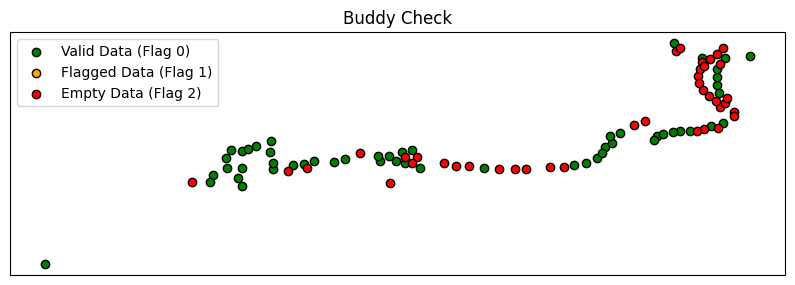

In [85]:
#Buddy check 
radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 10
max_elev_diff = 200
elev_gradient = -0.0065 ## think about inversion 


min_std = 2
num_iterations = 5
obs_to_check = np.full(points.size(), 1)

flags = titanlib.buddy_check(
    points, #Point object with station position
    temperature, 
    radius, # Search radius
    num_min, # The minimum number of buddies a station can have
    threshold, # the variance threshold for flagging a station
    max_elev_diff, # the maximum difference in elevation for a buddy (if negative will not check for heigh difference)
    elev_gradient, # linear elevation gradient with height
    min_std, # 	If the standard deviation of values in a neighborhood are less than min_std, min_std will be used instead
    num_iterations, # The number of iterations to perform
    obs_to_check # Observations that will be checked (since can pass in observations that will not be checked). 1=check the corresponding observation
)

print(flags)

# I can make an override where the missing data is flagged as 2 so it isn't disracting.
# Identify empty (NaN) data and set flags to 2
flags[np.isnan(temperature)] = 2  

print(flags)  # Now, flags will contain 0 (OK), 1 (bad), and 2 (empty)


# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Buddy Check")
ax.legend()

# Show the map
plt.show()

## Buddy event check  
This test is similar to the buddy check, except that observations are converted into yes/no values of exceeding a specified threshold. Doesn't make sense to use this for temperature. Would do for precip. 

In [48]:
# #Buddy event check

# radius = np.full(points.size(), 5000)
# num_min = np.full(points.size(), 1)
# event_threshold = 0.2
# threshold = 0.25
# max_elev_diff = 10
# elev_gradient = 0
# num_iterations = 5
# flags = titanlib.buddy_event_check(points, temperature, radius, num_min,
#             event_threshold, threshold, max_elev_diff, elev_gradient, num_iterations)

# print(flags)

# flags[np.isnan(temperature)] = 2  
# print(flags)

# # Extract indices based on flag values
# valid_indices = np.where(flags == 0)[0]  # Green: Valid data
# flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
# empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# # Create a map
# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# # Add map features
# ax.add_feature(cfeature.BORDERS, linestyle=":")
# ax.add_feature(cfeature.COASTLINE)

# # Plot valid observations (green)
# ax.scatter(
#     longitude[valid_indices], latitude[valid_indices],
#     c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Plot flagged observations (orange)
# ax.scatter(
#     longitude[flagged_indices], latitude[flagged_indices],
#     c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Plot empty data (red)
# ax.scatter(
#     longitude[empty_indices], latitude[empty_indices],
#     c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Add title & legend
# ax.set_title("Buddy Event Check")
# ax.legend()

# # Show the map
# plt.show()

## Climatology range check  
Flag if observation values are outside a user-defined range around climatological temperature values. For an observation, the climatology depends on the location and the time. I don't know where the climatology comes from so I think it is better to use the range check.

In [49]:
# #Range check climatology
# target_time = pd.to_datetime("2022-01-22T12:00:00")


# unixtime = int(target_time.timestamp()) #need this as input for climatology 
# tpos = np.full(points.size(), 300)
# tneg = np.full(points.size(), 299)

# flags = titanlib.range_check_climatology(points, temperature, unixtime, tpos, tneg)   #this climatology might be in C we are in K
# print(flags)
# flags[np.isnan(temperature)] = 2  
# print(flags)

# # Extract indices based on flag values
# valid_indices = np.where(flags == 0)[0]  # Green: Valid data
# flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
# empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# # Create a map
# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# # Add map features
# ax.add_feature(cfeature.BORDERS, linestyle=":")
# ax.add_feature(cfeature.COASTLINE)

# # Plot valid observations (green)
# ax.scatter(
#     longitude[valid_indices], latitude[valid_indices],
#     c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Plot flagged observations (orange)
# ax.scatter(
#     longitude[flagged_indices], latitude[flagged_indices],
#     c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Plot empty data (red)
# ax.scatter(
#     longitude[empty_indices], latitude[empty_indices],
#     c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
# )

# # Add title & legend
# ax.set_title("Climatology Range Check")
# ax.legend()

# # Show the map
# plt.show()

## Isolation check
Stations that are isolated in space are difficult to QC with spatial methods. The isolation check flags stations that have fewer than num_min buddies within a specified radius [m]. This wouldn't change much, unless we take into consideration stations that are going on and off, this doesn't do that at the moment.

[0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0]
[2 0 2 2 0 0 2 2 0 1 1 2 0 0 2 2 0 1 0 0 2 2 2 1 2 1 2 0 0 0 2 2 0 1 2 2 0
 1 2 1 1 0 0 2 0 0 0 0 2 2 1 2 2 0 1 2 2 0 0 2 2 2 2 1 1 1 0 2 2 0 2 2 0 0
 0 2 2 2 0 1 1 0 0 0 0 2 0 1 2 2 1 1 0 2]


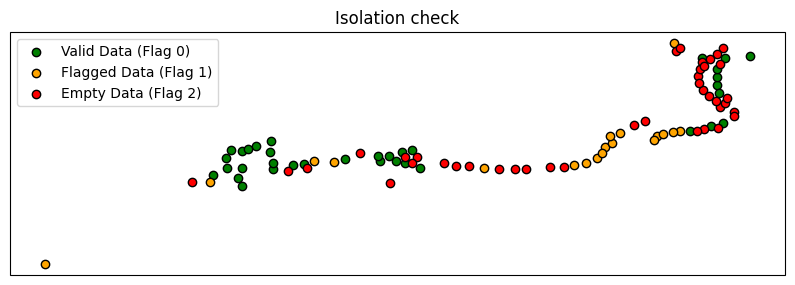

In [58]:
radius = 500 
nb_neigh = 10
vertical_radius = 100

flags = titanlib.isolation_check(points, 
                                 nb_neigh, #required number of observations
                                 radius, # search radius (m)
                                 vertical_radius) # veritcal search radius (m)
print(flags)
flags[np.isnan(temperature)] = 2  
print(flags)

# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Isolation check")
ax.legend()

# Show the map
plt.show()

## Metadata check
This check is doing strange things - it is supposed to flag stations with invalid latitude, longitude, and/or elevations. It is flagging my example data too. I wonder if it is comparing to a model DEM, the old version of titanlib used to have this test and I haven't found it in the new one.

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 1 2 2 1 1 2 2 1 1 1 2 1 1 2 2 1 1 1 1 2 2 2 1 2 1 2 1 1 1 2 2 1 1 2 2 1
 1 2 1 1 1 1 2 1 1 1 1 2 2 1 2 2 1 1 2 2 1 1 2 2 2 2 1 1 1 1 2 2 1 2 2 1 1
 1 2 2 2 1 1 1 1 1 1 1 2 1 1 2 2 1 1 1 2]


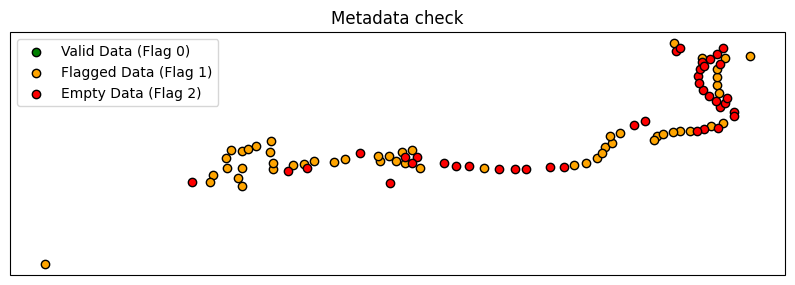

In [60]:
flags = titanlib.metadata_check(points, True, True, True, True)
print(flags)

# Identify empty (NaN) data and set flags to 2
flags[np.isnan(temperature)] = 2   
print(flags)

# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Metadata check")
ax.legend()

# Show the map
plt.show()

## Range check
Flag if observation values are outside a given minimum and maximum range. Can for example be used to check if the values are outside the range the sensor is able to measure, or outside the local recorded extremes.

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]
[2 0 2 2 0 0 2 2 0 0 0 2 0 0 2 2 0 0 0 0 2 2 2 0 2 0 2 0 0 0 2 2 0 0 2 2 0
 0 2 0 0 0 0 2 0 0 0 0 2 2 0 2 2 0 0 2 2 0 0 2 2 2 2 0 0 0 0 2 2 0 2 2 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 2]


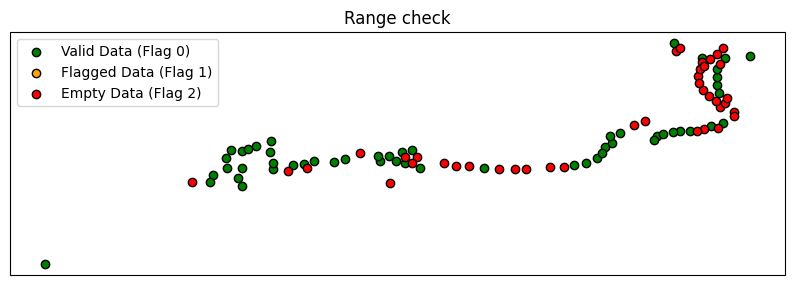

In [69]:
tpos = np.full(points.size(), 313.15) # 40C
tneg = np.full(points.size(), 223.15) # -50C

flags = titanlib.range_check(temperature, tneg, tpos)
print(flags)

# Identify empty (NaN) data and set flags to 2
flags[np.isnan(temperature)] = 2   
print(flags)

# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Range check")
ax.legend()

# Show the map
plt.show()

## Spatial consistency test 
The spatial consistency test (SCT) acts as a more sophisticated buddy check by evaluating the likelihood of an observation given the values observed by
the neighboring stations. The SCT uses optimal interpolation (OI) to compute an expected value for each observation. The background for the OI is computed from a general vertical profile of observations in the area. Since the SCT is computationally more expensive than the buddy check, the buddy check is used for thinning the observation dataset before applying the SCT. 
It is not possible to define SCT thresholds that are universally valid. 

I can include info on trustworthiness of data in eps2

Returns:
flags
prob_gross_error - Probability of gross error for each observation
rep - 	Coefficient of representativity


TODO - put in temp values


[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]
obs_to_check_test:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


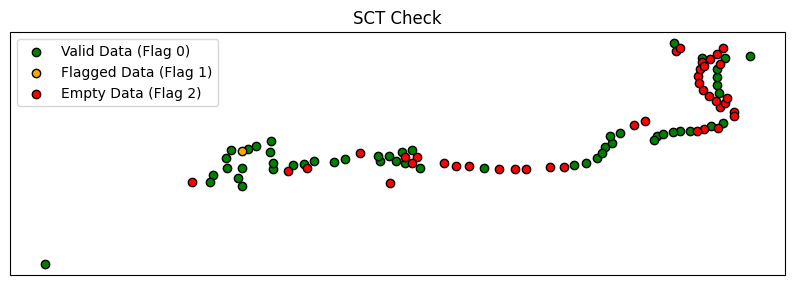

return1:  [2.1796923  1.8884714  0.3437063  1.2515522  4.4432483  1.1258346
 4.5285645  2.2024534  0.42813513 1.3514156  2.077839   4.0049105
 1.448577   7.102868   2.827474   2.6707528  2.9889066  2.1480913
 1.5470661  2.4544454  1.4018555  4.2997627  5.0769477  3.5993233
 3.034258   0.9548495  5.6193776  1.3319621  1.3238194  1.0129119
 3.5715184  1.9504414  1.0521394  1.4950752  2.9078448  3.704261
 2.2453377  1.8252528  1.6424893  1.7705972  2.388176   1.1060786
 1.2189193  3.8740578  8.084185   1.2553917  1.5640761  2.1439898
 3.0076973  1.3968053  1.1252235  0.9195275  0.22470844 2.3176079 ]
return2:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [87]:
## I should make a new dataset each time I run this as it may already have tests run on it

dataset = titanlib.Dataset(points, temperature)



#Do a simple check so that empty data is flagged, I will use Buddy check, it has to be one that allows Dataset tests
radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 2
max_elev_diff = 200
elev_gradient = -0.0065
min_std = 2
num_iterations = 5


##SCT TEST only works if I run a check first to get out the NaN data, I used buddy_check as a quick one.

dataset.buddy_check(
    radius,
    num_min,
    threshold,
    max_elev_diff,
    elev_gradient,
    min_std,
    num_iterations,
)

test = dataset.get_flags()
print(test)


pos = np.full(points.size(), 1) ## I messed with this
neg = np.full(points.size(), 1) ## I messed with this
eps2 = np.full(points.size(), 0.5)
obs_to_check_test = np.full(points.size(), 1) ##Is this how I get titanlib to only check the snowgun data not dwd?
num_min = 5
num_max = 10
inner_radius = 50000
outer_radius = 150000
num_iterations = 5
num_min_prof = 20
min_elev_diff = 200
min_horizonal_scale = 1000
vertical_scale = 200
print("obs_to_check_test: ", obs_to_check_test)


return1, return2 = dataset.sct(num_min, #Minimum number of observations to compute vertical profile
                               num_max,
                               inner_radius, #Radius for flagging
                               outer_radius, #Radius for computing OI and background
                               num_iterations,
                               num_min_prof, #Minimum number of observations to compute vertical profile
                               min_elev_diff, # Minimum elevation difference to compute vertical profile
                               min_horizonal_scale, # Minimum horizontal decorrelation length
                               vertical_scale, #Vertical decorrelation length
                               pos, # Positive deviation allowed
                               neg, # Negative deviation allowed
                               eps2,# Ratio of observation error variance to background variance (How much is the observation trusted 1: not trusted; 0.1 trusted a lot)
                               obs_to_check) #	Observations that will be checked (since can pass in observations that will not be checked). 1=check the corresponding observation)

print(dataset.get_flags())

flags = dataset.get_flags()
flags[np.isnan(temperature)] = 2   

# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("SCT Check")
ax.legend()

# Show the map
plt.show()

print("return1: ", return1)
print("return2: ", return2)

<div class="alert alert-danger"> 
Kernel keeps crashing if I run this on points, seems to work better as a dataset

I need to look into running it through buddy check first.

In [ ]:
# Spatial consistency test - Returned parameters Quality control flag (0=OK, 1=bad), 


# pos = np.full(points.size(), 4)
# neg = np.full(points.size(), 8)
# eps2 = np.full(points.size(), 0.5)

# flags, prob, rep = titanlib.sct(points,
#     temperature,
#     5,      # num_min
#     100,    # num_max
#     50000,  # inner_radius
#     150000, # outer_radius
#     1,      # num_iterations
#     20,     # num_min_prof
#     200,    # min_elev_diff
#     10000,  # min_horizonal_scale
#     200,    # vertical_scale
#     pos,
#     neg,
#     eps2)

# print(flags)
# print(prob)
# print(rep)

## Spatial consistency test resistant
The sct_resistant function offers a more outlier-resistant spatial consistency test (SCT) compared to the standard sct, though it typically operates at a slower pace.

In [74]:
## Spatial consistency test Resistant

dataset = titanlib.Dataset(points, temperature)
#Do a simple check so that empty data is flagged, I will use Buddy check, it has to be one that allows Dataset tests
radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 2
max_elev_diff = 200
elev_gradient = -0.0065
min_std = 2
num_iterations = 5



# dataset.buddy_check(
#     radius,
#     num_min,
#     threshold,
#     max_elev_diff,
#     elev_gradient,
#     min_std,
#     num_iterations,
# )

# test = dataset.get_flags()
# print(test)

pos = np.full(points.size(), 4)
neg = np.full(points.size(), 8)
eps2 = np.full(points.size(), 0.5)

obs_to_check = np.full(points.size(), 1)
background_values = np.full(points.size(), 0)
background_elab_type = titanlib.MedianOuterCircle
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 1
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200
tpos = np.full(points.size(), 16)
tneg = np.full(points.size(), 16)
eps2 = np.full(points.size(), 0.5)
values_mina = np.full(points.size(), -20)
values_maxa = np.full(points.size(), 20)
values_minv = np.full(points.size(), 0)
values_maxv = np.full(points.size(), 10)
debug = True
basic = True


flags, scores = titanlib.sct_resistant( points, temperature, obs_to_check, background_values, 
                      background_elab_type, num_min_outer, num_max_outer, 
                      inner_radius, outer_radius, num_iterations, num_min_prof, 
                      min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                      kth_closest_obs_horizontal_scale, vertical_scale, 
                      values_mina, values_maxa, values_minv, values_maxv, 
                      eps2, tpos, tneg, debug, basic)


# dataset.sct_resistant(obs_to_check, background_values, background_elab_type, num_min_outer, num_max_outer, 
#                        inner_radius, outer_radius, num_iterations, num_min_prof, 
#                        min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
#                        kth_closest_obs_horizontal_scale, vertical_scale, 
#                        values_mina, values_maxa, values_minv, values_maxv, 
#                        eps2, tpos, tneg, debug, basic)

RuntimeError: Cannot compute quantile on empty array

## First guess test
FGT, First Guess Test implements a streamlined version of the Spatial Consistency Test (SCT), which is less computationally intensive compared to OI-based (Optimal Interpolation) SCTs.

In [80]:
#Do a simple check so that empty data is flagged, I will use Buddy check, it has to be one that allows Dataset tests
#Buddy check 
radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 2
max_elev_diff = 200
elev_gradient = -0.0065
min_std = 2
num_iterations = 5
obs_to_check = np.full(points.size(), 1)

flags = titanlib.buddy_check(
    points, #Point object with station position
    temperature, 
    radius, # Search radius
    num_min, # The minimum number of buddies a station can have
    threshold, # the variance threshold for flagging a station
    max_elev_diff, # the maximum difference in elevation for a buddy (if negative will not check for heigh difference)
    elev_gradient, # linear elevation gradient with height
    min_std, # 	If the standard deviation of values in a neighborhood are less than min_std, min_std will be used instead
    num_iterations, # The number of iterations to perform
    obs_to_check # Observations that will be checked (since can pass in observations that will not be checked). 1=check the corresponding observation
)


N = len(latitude)
obs_to_check = flags
background_values = np.zeros(N)
background_uncertainties = np.ones(N)
background_elab_type = titanlib.MedianOuterCircle
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 0
min_elev_diff = 100
min_horizontal_scale = 250
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
tpos = np.ones(N) * 5
tneg = np.ones(N) * 5
values_mina = temperature - 20
values_maxa = temperature + 20
values_minv = temperature - 1
values_maxv = temperature + 1
debug = True
basic = True
print("Starting FGT function with debug=True")
print(f"Debug mode is set to: {debug}")

flags = titanlib.fgt(points, temperature, obs_to_check,
    background_values, 
    background_uncertainties, 
    background_elab_type, 
    num_min_outer, 
    num_max_outer, 
    inner_radius, 
    outer_radius, 
    num_iterations, 
    num_min_prof, 
    min_elev_diff, 
    values_mina, 
    values_maxa, 
    values_minv, 
    values_maxv, 
    tpos, 
    tneg, 
    debug, 
    basic   
)

print(flags)

flags[np.isnan(temperature)] = 2  

# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data
empty_indices = np.where(flags == 2)[0]  # Red: Empty data


# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot empty data (red)
ax.scatter(
    longitude[empty_indices], latitude[empty_indices],
    c="red", label="Empty Data (Flag 2)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("SCT Check")
ax.legend()

# Show the map
plt.show()

Starting FGT function with debug=True
Debug mode is set to: True
[array([   0, -999,    0,    0, -999, -999,    0,    0, -999, -999, -999,
          0, -999, -999,    0,    0, -999, -999, -999, -999,    0,    0,
          0, -999,    0, -999,    0, -999, -999, -999,    0,    0, -999,
       -999,    0,    0, -999, -999,    0, -999, -999, -999, -999,    0,
       -999, -999, -999, -999,    0,    0, -999,    0,    0, -999, -999,
          0,    0, -999, -999,    0,    0,    0,    0, -999, -999, -999,
       -999,    0,    0, -999,    0,    0, -999, -999, -999,    0,    0,
          0, -999, -999, -999, -999, -999, -999, -999,    0, -999, -999,
          0,    0, -999, -999, -999,    0], dtype=int32), array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999.

TypeError: only integer scalar arrays can be converted to a scalar index

## Spatial consistency test dual 
sct_dual is based on the concept of an event, which may or may not occur at a specific location. The Spatial Consistency Test (SCT) is applied to dichotomous variables, such as 'Yes-event: the event occurred' or 'No-event: the event did not occur.' Probably not useful for temperature. 

<div class="alert alert-danger"> 
I haven't gotten this test working

In [ ]:
# N = len(lats)
# obs_to_check = np.ones(N)
# event_thresholds = 0.1
# test_thresholds = 0.8
# #condition = titanlib.Gt

# condition = titanlib.MedianOuterCircle

# num_min_outer = 3
# num_max_outer = 10
# inner_radius = 20000
# outer_radius = 50000
# num_iterations = 10
# min_horizontal_scale = 250 
# max_horizontal_scale = 100000
# kth_closest_obs_horizontal_scale = 2
# vertical_scale = 200
# debug = True
# titanlib.sct_dual(points, temp_obs, obs_to_check, event_thresholds, condition,
#                  num_min_outer, num_max_outer, inner_radius, outer_radius,
#                  num_iterations, min_horizontal_scale, max_horizontal_scale,
#                  kth_closest_obs_horizontal_scale, vertical_scale,
#                  test_thresholds, debug)

## Plotting temporal data

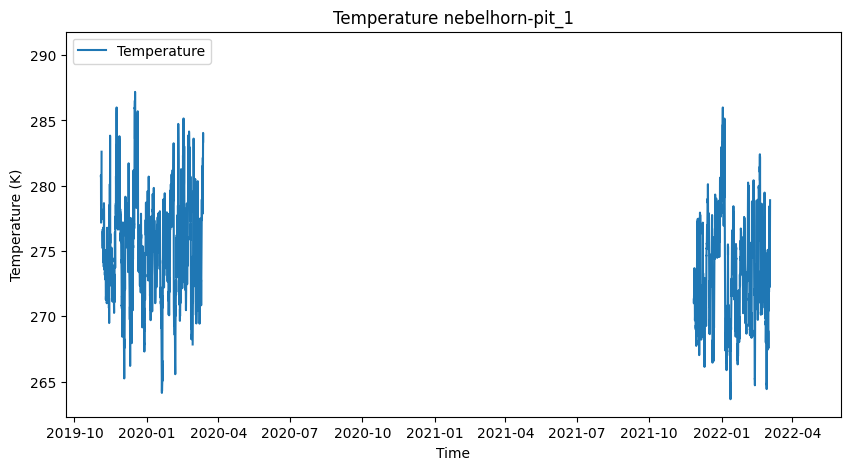

In [18]:
#Plotting time series of snowgun data
import netCDF4 as nc 
import xarray as xr   
import numpy as np    
import matplotlib.pyplot as plt  


# Enable inline plotting in Jupyter
%matplotlib inline


file_path = "/mnt/c/Users/c707165/Documents/Schneeprophet/Data_cleaning/nebelhorn/nebelhorn-pit_1.nc"
dataset = nc.Dataset(file_path, mode='r')

# Print metadata
# print(dataset)
ds = xr.open_dataset(file_path)
# print(ds)
# print(dataset.variables.keys())  # For netCDF4
# print(ds.variables)  # For xarray
temperature = ds['temp'].values  # Extract temperature data
time = ds['time'].values  # Extract time data

plt.figure(figsize=(10, 5))
plt.plot(time, temperature, label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.title("Temperature "+os.path.splitext(os.path.basename(file_path))[0])
plt.legend()
plt.show()